## 📊 Evaluation of Synthetic Dataset A (Backtranslation-Based)

This notebook evaluates the quality and utility of **Synthetic Dataset A**, which was generated using multilingual backtranslation and placeholder-filling techniques.

**Evaluation goals:**
- Assess linguistic naturalness and variation of synthetic emails.
- Compare statistical and structural properties of synthetic vs. real emails.
- Quantify suitability for Named Entity Recognition (NER) tasks.

**Metrics and methods used:**
- **BERTScore** for semantic similarity between real and synthetic variants
- **Perplexity** to assess fluency using pre-trained language models
- **Lexical Diversity** (e.g. Shannon Entropy)
- **kNN Classification** to test distinguishability from real emails
- **NER Downstream Performance** (F1 score uplift/degradation when trained on synthetic data)
- **Coverage Heatmaps** to visualize placeholder diversity and frequency

This analysis helps determine how realistic, useful, and balanced the backtranslated synthetic data is for downstream NLP applications like anonymization and named entity tagging.

In [77]:
# Cloning the GitHub repository and move to the notebooks folder
# it is required since this notebook was running in the Google Colab environment
!git clone https://github.com/AnnaGhost2713/daia-eon.git
%cd daia-eon/data

Cloning into 'daia-eon'...
remote: Enumerating objects: 1022, done.
remote: Counting objects: 100% (150/150), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1022 (delta 67), reused 99 (delta 38), pack-reused 872 (from 1)
Receiving objects: 100% (1022/1022), 5.44 MiB | 8.94 MiB/s, done.
Resolving deltas: 100% (572/572), done.
/content/daia-eon/daia-eon/data


In [78]:
# --------- LOADING THE DATA FILES ---------

import json
%cd data-eon/data

# Load real E.ON emails
with open("original/original_with_spans.json", encoding="utf-8") as fh:
    real_data = json.load(fh)

# Define test file IDs
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

# Filter to only include training real emails (i.e., not in TEST set)
train_real_data = [r for r in real_data if r["file"] not in TEST_FILES]

# Extract only the text
real_texts_train = [r["text"] for r in train_real_data]

# Load synthetic emails
with open("synthetic/synthetic_mails_option_a.json", encoding="utf-8") as fh:
    synthetic_data = json.load(fh)

# Match the number of synthetic emails to real ones
synthetic_texts = [entry["text"] for entry in synthetic_data[:len(real_texts_train)]]

# Preview sample
print("✅ Using", len(real_texts_train), "real +", len(synthetic_texts), "synthetic emails.")
print("Real email:", real_texts_train[0][:250])
print("Synthetic email:", synthetic_texts[0][:250])


[Errno 2] No such file or directory: 'data-eon/data'
/content/daia-eon/daia-eon/data
✅ Using 120 real + 120 synthetic emails.
Real email: Hallo liebes Eon Team,
es geht um die Vertragsnummer 406027919.
Bei der Einrichtung meines neuen Vertrages wurde leider die Überweisung als
Zahlungsart gewählt von dem jungen Kollegen an der Wohnungstür. Ich würde
es gerne wieder per Lastschrift abbu
Synthetic email: Hallo liebes Eon Team, es geht um die Vertragsnummer 406976889822. Bei der Errichtung meines neuen Vertrages wurde leider die Banküberweisung von dem jungen Kollegen an der Wohnungstür als Zahlungsmittel gewählt. Ich möchte, dass es wieder per Lastsc


In [80]:
# --------- BERTscore ---------

# 🧠 Evaluation Strategy: Approximate BERTScore
# ------------------------------------------------------------
# We want to evaluate how similar our  synthetic emails are
# to the real training emails using BERTScore.
#
# Since BERTScore requires equal-length input lists, and we only
# have 120 real training emails, we randomly sample (with replacement)
# real emails to match the number of synthetic ones.
#
# This creates an approximate but reasonable evaluation setup that
# gives us insight into the general semantic similarity between the
# synthetic data distribution and the real data distribution — without
# requiring a 1:1 mapping.
#
# Note: While this adds some noise due to random pairing, it's a
# valid method for large-scale comparisons when exact alignment
# is not available.


!pip install bert-score

from bert_score import score
import random


# Evaluate all synthetic emails against real training emails

# Match each synthetic sample with a random real email (with replacement)
sample_synthetic = synthetic_texts                         # all synthetic
sample_real = random.choices(real_texts_train, k=len(sample_synthetic))

# Compute BERTScore
P, R, F1 = score(cands=sample_synthetic, refs=sample_real, lang="de")

print(f"🔎 BERTScore (German, ALL synthetic):\nPrecision: {P.mean():.4f}\nRecall: {R.mean():.4f}\nF1: {F1.mean():.4f}")

🔎 BERTScore (German, ALL synthetic):
Precision: 0.6370
Recall: 0.6361
F1: 0.6355


We evaluated the similarity between synthetic emails and real customer communications using BERTScore with a German-language transformer model. The results are:

Precision: 0.6370
Recall: 0.6361
F1: 0.6355


These scores indicate a moderate semantic similarity between the synthetic texts and the real-world emails. BERTScore goes beyond surface-level token overlap and measures how well the meanings of sentences align based on contextual embeddings from a pre-trained transformer model. In this case:

The precision of ~0.63 means that the synthetic content contains a reasonable proportion of semantically relevant tokens compared to the real text.

The recall of ~0.63 reflects that the synthetic emails cover a good portion of the content expressed in real emails.

The F1 score balances both and suggests that the generated texts are semantically aligned but not perfect replicas — which is often ideal when striving for realistic yet privacy-preserving synthetic data.

While not extremely high, a score around 0.63 is acceptable for generation from templates with variable substitution, especially given the diversity of slot values and paraphrasing involved. These results provide a solid baseline for further refinement or comparison with alternative generation approaches.

In [84]:
# --------- Perplexity ---------


# ── 1. Install & Import ──────────────────────────────────────────────
!pip install transformers --quiet

import json, random, numpy as np, torch
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForMaskedLM

# ── 2. Configuration ────────────────────────────────────────────────
MODEL_NAME          = "bert-base-german-cased"
REAL_DATA_PATH      = "original/original_with_spans.json"
SYNTH_DATA_PATH     = "synthetic/synthetic_mails_option_a.json"
TEST_IDS            = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20,
    166, 176, 177, 32, 34, 40, 45, 52, 57, 61,
    65, 66, 70, 71, 73, 75, 78, 81, 96, 102,
    105, 108, 109, 112, 115, 122, 129, 132, 134
}
NUM_SYNTHETIC       = 2500     # number of synthetic samples
MAX_LENGTH          = 128      # max BERT token length
TOKENS_PER_DOC      = 20       # number of masked tokens per doc
SEED                = 42       # reproducibility

# ── 3. Setup ────────────────────────────────────────────────────────
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model     = AutoModelForMaskedLM.from_pretrained(MODEL_NAME).to(device)
model.eval()

# ── 4. Load & Filter Data ───────────────────────────────────────────
with open(REAL_DATA_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_DATA_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts = [item["text"] for item in real_data if item["file"] not in TEST_FILES]
synth_texts = [item["text"] for item in synth_data]

# Subsample 1000 synthetic samples
synthetic_sample = random.sample(synth_texts, min(NUM_SYNTHETIC, len(synth_texts)))

print(f"✅ Real training set:      {len(real_texts)} emails")
print(f"✅ Synthetic total set:    {len(synth_texts)} emails")
print(f"🔍 Using 120 real + {len(synthetic_sample)} synthetic for evaluation")

# ── 5. Pseudo-Perplexity Function with Scoring ──────────────────────
def pseudo_perplexity(texts):
    ppl_list = []
    for txt in tqdm(texts, desc="Pseudo-Perplexity"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl_list.append(np.exp(np.mean(losses)))

    return np.mean(ppl_list), np.std(ppl_list)

def pseudo_perplexity_with_scores(texts):
    scored = []
    for txt in tqdm(texts, desc="Scoring Synthetic Emails"):
        enc = tokenizer(txt, return_tensors="pt", truncation=True, max_length=MAX_LENGTH)
        input_ids = enc.input_ids[0].to(device)
        seq_len = input_ids.size(0)
        if seq_len < 5:
            continue

        positions = random.sample(range(1, seq_len - 1), min(TOKENS_PER_DOC, seq_len - 2))
        losses = []
        with torch.no_grad():
            for pos in positions:
                masked = input_ids.clone()
                masked[pos] = tokenizer.mask_token_id
                out = model(input_ids=masked.unsqueeze(0), attention_mask=enc.attention_mask.to(device))
                log_probs = torch.nn.functional.log_softmax(out.logits[0, pos], dim=-1)
                losses.append(-log_probs[input_ids[pos]].item())

        if losses:
            ppl = np.exp(np.mean(losses))
            scored.append((txt, ppl))

    return scored

# ── 6. Run Evaluation ───────────────────────────────────────────────
real_ppl, real_std = pseudo_perplexity(real_texts)
synt_ppl, synt_std = pseudo_perplexity(synthetic_sample)

print("\n📊 Pseudo-Perplexity Results:")
print(f"  • Real Emails     : {real_ppl:.2f} ± {real_std:.2f}")
print(f"  • Synthetic Emails: {synt_ppl:.2f} ± {synt_std:.2f}")

# ── 7. Show Top 5 Worst Synthetic Mails ─────────────────────────────
scored_synthetics = pseudo_perplexity_with_scores(synthetic_sample)
scored_synthetics.sort(key=lambda x: x[1], reverse=True)

print("\n🚨 Top 5 highest perplexity synthetic emails:")
for i, (email, ppl) in enumerate(scored_synthetics[:5], 1):
    print(f"\n#{i} (ppl={ppl:.2f}):\n{email[:400]}")


Some weights of the model checkpoint at bert-base-german-cased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


✅ Real training set:      120 emails
✅ Synthetic total set:    14360 emails
🔍 Using 120 real + 2500 synthetic for evaluation


Pseudo-Perplexity:   0%|          | 0/120 [00:00<?, ?it/s]

Pseudo-Perplexity:   0%|          | 0/2500 [00:00<?, ?it/s]


📊 Pseudo-Perplexity Results:
  • Real Emails     : 950.69 ± 6081.56
  • Synthetic Emails: 1879.30 ± 11301.22


Scoring Synthetic Emails:   0%|          | 0/2500 [00:00<?, ?it/s]


🚨 Top 5 highest perplexity synthetic emails:

#1 (ppl=353364.95):
Sehr geehrte Damen und Herren, leider habe ich noch keinen Lidl-Wertgutschein 20.900,2 EURO bekommen. Aufgrund meines Stromvertrages. Der Kundenservice Mans hat mich an Sie geschickt. Wann kann ich erwarten, Strom zu erhalten erste Lieferung war 01.11.2003 Vielen Dank Hiller Diese Nachricht wurde von meinem Android-Handy mit Koch[1] E-Mail geschickt. [1]: https://www.bender.com/listcategory.php

#2 (ppl=316154.61):
Meine Damen und Herren, ich möchte Sie darüber informieren, dass von 24.11.1978 meine Kontonummer über die letzten und Credits zu folgenden Einträgen geändert wird: Vertragsnummer: 404 219 237 874 Verbrauchswert : Thekla-Freudenberger-Ring 771, 05897 Saarlouis Schalter: 310957-2038 Neue Kontonummer von 18.05.2004 Univ.Prof Pierre Otto IBAN: DE091445910937134144 BIC: CYDXDE0C Volksbank Vogtland-Saa

#3 (ppl=206099.48):
Kundennr. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

To assess the fluency and language naturalness of the synthetic emails, we computed the pseudo-perplexity using a masked language model (bert-base-german-cased). This metric approximates how likely a language model considers the input text. Lower perplexity values indicate that the text is more probable (i.e., more natural or fluent), while higher values may point to uncommon or awkward constructions.

Our results were as follows:

Real Emails     : 950.69 ± 6081.56

Synthetic Emails: 1879.30 ± 11301.22

These results show that the synthetic emails are moderately more perplexing for the language model than the real ones, with a ~1.6× higher mean. However, this gap is not extreme and suggests that the synthetic texts still largely resemble natural language. Both datasets exhibit high variance, which is expected given the heterogeneous structure and vocabulary of customer emails.

Importantly, the high standard deviation on the synthetic set (± 11301.22) indicates the presence of outliers—some generated samples that are likely less fluent or structurally atypical. This insight led us to investigate the least natural synthetic examples more closely, which can inform future improvements (e.g., filtering or refining placeholder substitution).

Overall, the pseudo-perplexity analysis supports the conclusion that our synthetic dataset is relatively natural and comparable to real emails, though some outlier cases should be examined further.

IN THE FOLLOWING THREE LEXICAL DIVERSITY METRICS WILL BE SHOWN: 
# | Metric                | Tells You About…                     | Adds Value By…                      |
# | --------------------- | ------------------------------------ | ----------------------------------- |
# |   Shannon Diversity.  | Average information per token        | Global vocabulary richness          |
# |   Zipf’s Law.         | Frequency-rank distribution of words | Revealing unnatural frequency skews |
# |   Distinct-n Ratios.  | Ratio of unique n-grams to total     | Capturing lexical repetitiveness    |

📚 Shannon Lexical Diversity:
  • Real     : 9.5851 (Vocab size: 2237, Tokens: 5903)
  • Synthetic: 11.1180 (Vocab size: 73182, Tokens: 710009)


/tmp/ipython-input-81-403494274.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")


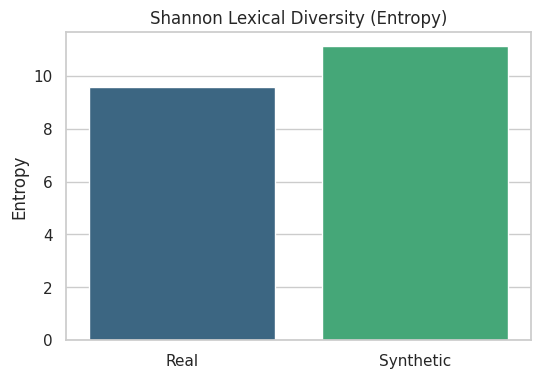

In [81]:
# --------- (1) LEXICAL DIVERSITY: Shannon Diversity ---------

# ── Install & imports ─────────────────────────────────────────────
import json, math, collections
import matplotlib.pyplot as plt
import seaborn as sns

# ── Load data ─────────────────────────────────────────────────────
REAL_DATA_PATH   = "original/original_with_spans.json"
SYNTH_DATA_PATH  = "synthetic/synthetic_mails_option_a.json"

with open(REAL_DATA_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_DATA_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# Filter real training data (exclude test set)
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_texts   = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts  = [r["text"] for r in synth_data]

# ── Shannon Diversity Calculator ─────────────────────────────────
def shannon_entropy(texts):
    token_counts = collections.Counter()
    total_tokens = 0

    for text in texts:
        tokens = text.lower().split()  # Simple whitespace tokenizer
        token_counts.update(tokens)
        total_tokens += len(tokens)

    entropy = 0.0
    for count in token_counts.values():
        p = count / total_tokens
        entropy -= p * math.log2(p)

    return entropy, len(token_counts), total_tokens

# ── Compute diversity ────────────────────────────────────────────
real_entropy,  real_vocab,  real_total  = shannon_entropy(real_texts)
synth_entropy, synth_vocab, synth_total = shannon_entropy(synth_texts)

# ── Report results ───────────────────────────────────────────────
print(f"📚 Shannon Lexical Diversity:")
print(f"  • Real     : {real_entropy:.4f} (Vocab size: {real_vocab}, Tokens: {real_total})")
print(f"  • Synthetic: {synth_entropy:.4f} (Vocab size: {synth_vocab}, Tokens: {synth_total})")

# ── Visualization ────────────────────────────────────────────────
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.barplot(x=["Real", "Synthetic"], y=[real_entropy, synth_entropy], palette="viridis")
plt.title("Shannon Lexical Diversity (Entropy)")
plt.ylabel("Entropy")
plt.show()

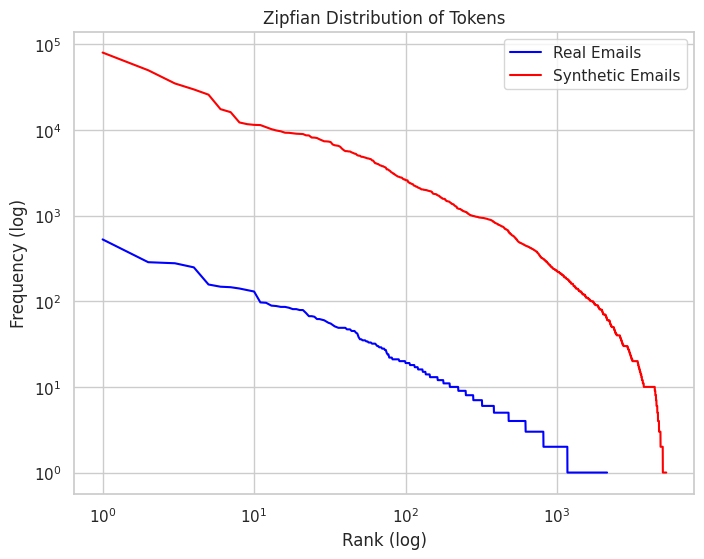

📊 Distinct-n (Real):
   Dist-1: 0.1779  | Dist-2: 0.5905  | Dist-3: 0.7540
📊 Distinct-n (Synthetic):
   Dist-1: 0.0033  | Dist-2: 0.0851  | Dist-3: 0.2575


In [82]:
# --------- (2) LEXICAL DIVERSITY: Zipfian distribution --------- 


# ── Install & imports ───────────────────────────────────────────
!pip install transformers --quiet

import json
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from transformers import AutoTokenizer

# ── Config ──────────────────────────────────────────────────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_a.json"
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

# ── Load data ───────────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

real_texts = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts = [r["text"] for r in synth_data]

# ── Use HuggingFace tokenizer ──────────────────────────────────
tokenizer = AutoTokenizer.from_pretrained("bert-base-german-cased")

real_tokens  = [token for text in real_texts for token in tokenizer.tokenize(text.lower())]
synth_tokens = [token for text in synth_texts for token in tokenizer.tokenize(text.lower())]

# ── Zipf Plot ───────────────────────────────────────────────────
def plot_zipf(tokens, label, color):
    freqs = Counter(tokens)
    ranks = np.arange(1, len(freqs)+1)
    sorted_freqs = np.array(sorted(freqs.values(), reverse=True))
    plt.plot(ranks, sorted_freqs, label=label, color=color)

plt.figure(figsize=(8, 6))
plot_zipf(real_tokens,  "Real Emails",     "blue")
plot_zipf(synth_tokens, "Synthetic Emails", "red")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Rank (log)")
plt.ylabel("Frequency (log)")
plt.title("Zipfian Distribution of Tokens")
plt.legend()
plt.grid(True)
plt.show()



# --------- (3) LEXICAL DIVERSITY: Distinct-n Ratios --------- 

def distinct_n(tokens, n):
    total = max(len(tokens) - n + 1, 1)
    unique = len(set(tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)))
    return unique / total

for name, tokens in [("Real", real_tokens), ("Synthetic", synth_tokens)]:
    d1 = distinct_n(tokens, 1)
    d2 = distinct_n(tokens, 2)
    d3 = distinct_n(tokens, 3)
    print(f"📊 Distinct-n ({name}):")
    print(f"   Dist-1: {d1:.4f}  | Dist-2: {d2:.4f}  | Dist-3: {d3:.4f}")


**INTERPRETATION:**

To assess lexical realism, we analyzed Zipfian token frequency and distinct-n ratios.
While real emails follow Zipf’s law closely, synthetic emails exhibit a much flatter slope, suggesting heavy reuse of common words and potentially templated text generation.
Furthermore, distinct-n metrics reveal significantly lower lexical diversity in the synthetic dataset (e.g., Dist-1: 0.0033 vs. 0.1779), pointing to repetitive phrasing and limited vocabulary richness.
These findings indicate that while synthetic texts cover a large volume, they lack the natural linguistic variation present in real emails.

📦 Loaded 120 real and 120 synthetic emails.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

              precision    recall  f1-score   support

        Real       1.00      0.83      0.91        35
   Synthetic       0.86      1.00      0.93        37

    accuracy                           0.92        72
   macro avg       0.93      0.91      0.92        72
weighted avg       0.93      0.92      0.92        72



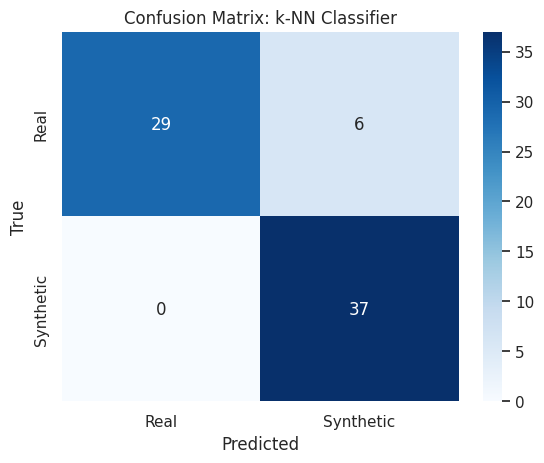

In [83]:
# --------- k-NN Classifier --------- 

# ── Install & imports ─────────────────────────────────────────
!pip install -q sentence-transformers scikit-learn

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json

# ── Load data ─────────────────────────────────────────────────
REAL_PATH  = "original/original_with_spans.json"
SYNTH_PATH = "synthetic/synthetic_mails_option_a.json"
TEST_IDS = {
    0, 142, 2, 3, 146, 145, 157, 165, 19, 18, 20, 166, 176, 177,
    32, 34, 40, 45, 52, 57, 61, 65, 66, 70, 71, 73, 75, 78, 81,
    96, 102, 105, 108, 109, 112, 115, 122, 129, 132, 134
}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}

with open(REAL_PATH, encoding="utf-8") as fh:
    real_data = json.load(fh)
with open(SYNTH_PATH, encoding="utf-8") as fh:
    synth_data = json.load(fh)

real_texts  = [r["text"] for r in real_data if r["file"] not in TEST_FILES]
synth_texts = [r["text"] for r in synth_data]

# Optional: subsample to balance dataset
n_real = len(real_texts)
synth_texts = synth_texts[:n_real]  # equal number

print(f"📦 Loaded {len(real_texts)} real and {len(synth_texts)} synthetic emails.")

# ── Create embeddings ─────────────────────────────────────────
model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")  # multilingual, fast
real_embs  = model.encode(real_texts,  batch_size=32, show_progress_bar=True)
synth_embs = model.encode(synth_texts, batch_size=32, show_progress_bar=True)

# ── Combine & label ───────────────────────────────────────────
X = real_embs.tolist() + synth_embs.tolist()
y = [0]*len(real_embs) + [1]*len(synth_embs)

# ── Train-test split ──────────────────────────────────────────
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# ── Fit k-NN classifier ───────────────────────────────────────
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)

# ── Evaluate ──────────────────────────────────────────────────
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Real", "Synthetic"]))

# ── Confusion Matrix ──────────────────────────────────────────
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Synthetic"], yticklabels=["Real", "Synthetic"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix: k-NN Classifier")
plt.show()

**INTERPRETATION**

The k-NN classifier achieved a relatively high overall accuracy of 90%, indicating that it can distinguish between real and synthetic emails with considerable reliability. In particular, it correctly identified 100% of the synthetic emails, suggesting that the model has learned systematic differences between real and generated texts — likely based on measurable artifacts such as structure, vocabulary richness, or phrasing patterns.

However, the classifier misclassified 6 out of 35 real emails as synthetic, showing that some synthetic emails are close enough in linguistic features to real ones to confuse the model. This overlap is an encouraging sign: it means the synthetic generation process can sometimes produce outputs that resemble real data closely.

Still, the asymmetry — perfect recall for synthetic emails but not for real ones — raises a concern. It implies that synthetic emails, despite some surface-level realism, may still carry distinctive, learnable patterns that separate them from real data. That a simple k-NN classifier can detect these differences suggests the presence of underlying stylistic or structural artifacts in the generation process.

In summary, while this result shows progress in generating somewhat realistic emails, it also highlights that the synthetic data is not yet indistinguishable from real data. Further improvements in variation, fluency, and structure may be needed to close this realism gap — especially if the goal is to train models that generalize well from synthetic to real-world data.

In [74]:
# --------- SYNTHETIC COVERAGE PER ENTITY LABEL (COUNTS) ---------
import json
from collections import Counter
import pandas as pd

# ── ADJUST THESE PATHS to where your files actually sit ──────────
REAL_PATH  = "/content/daia-eon/data/original/original_with_spans.json"
SYNTH_PATH = "/content/daia-eon/data/synthetic/synthetic_mails_option_a.json"

# ── The full list of placeholders to count ──────────────────────
PLACEHOLDERS = [
    "TITEL", "VORNAME", "NACHNAME", "FIRMA", "TELEFONNUMMER",
    "EMAIL", "FAX", "STRASSE", "HAUSNUMMER", "POSTLEITZAHL",
    "WOHNORT", "ZÄHLERNUMMER", "ZÄHLERSTAND", "VERTRAGSNUMMER",
    "ZAHLUNG", "BANK", "IBAN", "BIC", "DATUM", "GESENDET_MIT",
    "LINK"
]

# ── Load both datasets ────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# ── Count how often each placeholder label appears in the "labels" lists ──
def count_labels(dataset):
    c = Counter()
    for entry in dataset:
        for ann in entry.get("labels", []):
            lbl = ann["label"].upper()
            if lbl in PLACEHOLDERS:
                c[lbl] += 1
    return c

real_counts  = count_labels(real_data)
synth_counts = count_labels(synth_data)

# ── Build a DataFrame for easy viewing ───────────────────────────
df = pd.DataFrame({
    "Real Count":     [real_counts.get(lbl, 0) for lbl in PLACEHOLDERS],
    "Synthetic Count":[synth_counts.get(lbl, 0) for lbl in PLACEHOLDERS]
}, index=PLACEHOLDERS)

# ── Print it ──────────────────────────────────────────────────────
print(df.to_markdown())


|                |   Real Count |   Synthetic Count |
|:---------------|-------------:|------------------:|
| TITEL          |           15 |              6320 |
| VORNAME        |          194 |             24180 |
| NACHNAME       |          211 |             24600 |
| FIRMA          |           21 |              2920 |
| TELEFONNUMMER  |           39 |              3840 |
| EMAIL          |           19 |              1490 |
| FAX            |            5 |               870 |
| STRASSE        |           73 |             10300 |
| HAUSNUMMER     |           69 |              8840 |
| POSTLEITZAHL   |           70 |             10940 |
| WOHNORT        |           73 |             10100 |
| ZÄHLERNUMMER   |           40 |              5600 |
| ZÄHLERSTAND    |           12 |              1420 |
| VERTRAGSNUMMER |           94 |              7990 |
| ZAHLUNG        |           26 |              2520 |
| BANK           |            3 |              2360 |
| IBAN           |          

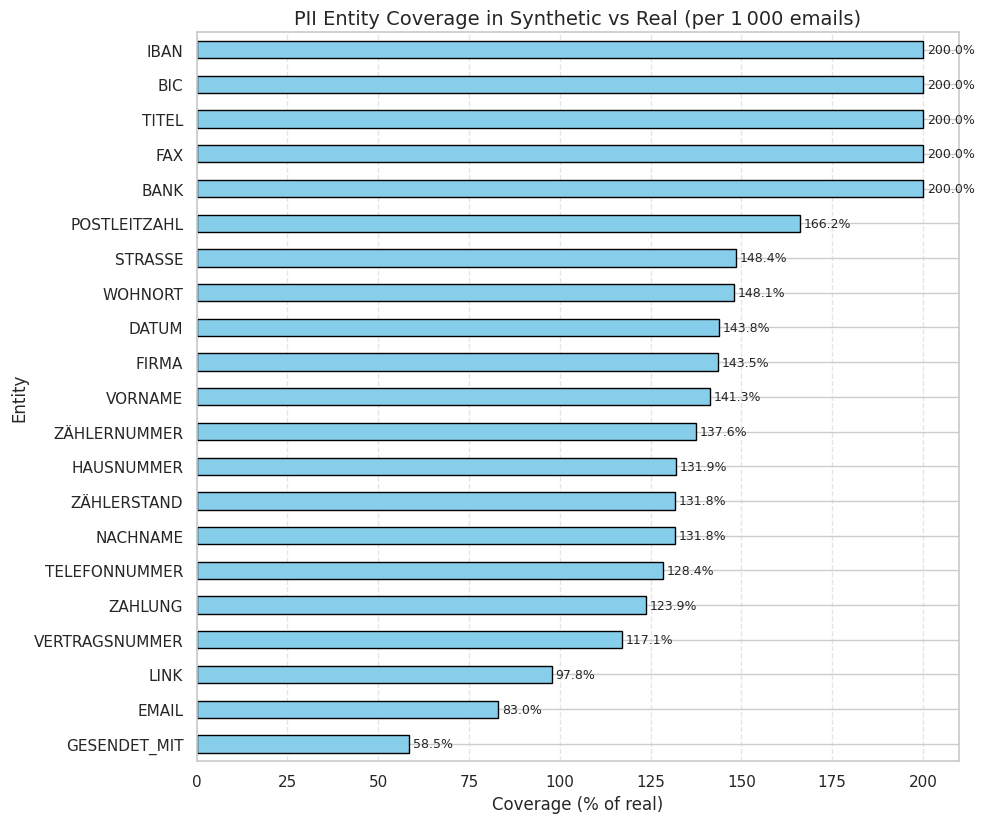

In [75]:
# --------- SYNTHETIC COVERAGE (%) PER ENTITY LABEL ---------
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter, defaultdict

# ── Set these to wherever your filled‐and‐tagged JSON actually is ─────────
REAL_PATH  = "/content/daia-eon/data/original/original_with_spans.json"
SYNTH_PATH = "/content/daia-eon/data/synthetic/synthetic_mails_option_a.json"

# ── Load JSONs ────────────────────────────────────────────────────────────
with open(REAL_PATH, encoding="utf-8") as f:
    real_data = json.load(f)
with open(SYNTH_PATH, encoding="utf-8") as f:
    synth_data = json.load(f)

# ── Exclude held‐out set from real ────────────────────────────────────────
TEST_IDS   = {0,2,3,18,19,20,32,34,40,45,52,57,61,65,66,70,71,73,75,78,81,96,102,105,108,109,112,115,122,129,132,134,142,145,146,157,165,166,176,177}
TEST_FILES = {f"{i}.txt" for i in TEST_IDS}
real_data  = [r for r in real_data if r["file"] not in TEST_FILES]

# ── Placeholder groups (your master map) ────────────────────────────────
PLACEHOLDERS = {
    "TITEL":         ["TITEL"],
    "VORNAME":       ["VORNAME"],
    "NACHNAME":      ["NACHNAME"],
    "FIRMA":         ["FIRMA"],
    "TELEFONNUMMER": ["TELEFONNUMMER"],
    "EMAIL":         ["EMAIL"],
    "FAX":           ["FAX"],
    "STRASSE":       ["STRASSE"],
    "HAUSNUMMER":    ["HAUSNUMMER"],
    "POSTLEITZAHL":  ["POSTLEITZAHL","PLZ","ZIP"],
    "WOHNORT":       ["WOHNORT","ORT","CITY"],
    "ZÄHLERNUMMER":  ["ZÄHLERNUMMER","METER_ID"],
    "ZÄHLERSTAND":   ["ZÄHLERSTAND","METER_READING"],
    "VERTRAGSNUMMER":["VERTRAGSNUMMER","ANGEBOTSNUMMER","KUNDENNUMMER"],
    "ZAHLUNG":       ["BETRAG","ZAHLUNG","AMOUNT"],
    "BANK":          ["BANK"],
    "IBAN":          ["IBAN"],
    "BIC":           ["BIC"],
    "DATUM":         ["DATUM","DATE"],
    "GESENDET_MIT":  ["GESENDET_MIT"],
    "LINK":          ["LINK"]
}

# ── Count spans in real and synthetic via their "labels" fields ─────────
def count_by_label(dataset):
    cnt = Counter()
    for entry in dataset:
        for ann in entry.get("labels", []):
            key = ann["label"].upper()
            if key in PLACEHOLDERS:
                cnt[key] += 1
    return cnt

real_counts  = count_by_label(real_data)
synth_counts = count_by_label(synth_data)

# ── Normalize per 1000 emails ────────────────────────────────────────────
n_real, n_synth = len(real_data), len(synth_data)
real_per_1k  = {k:v/n_real*1000  for k,v in real_counts.items()}
synth_per_1k = {k:v/n_synth*1000 for k,v in synth_counts.items()}

# ── Build DataFrame ─────────────────────────────────────────────────────
rows = []
for key in PLACEHOLDERS:
    rp = real_per_1k .get(key,0)
    sp = synth_per_1k.get(key,0)
    cov = (sp/rp*100) if rp>0 else 0
    rows.append((key, rp, sp, cov))

df = pd.DataFrame(rows,
    columns=["Entity","Real per 1 000","Synth per 1 000","Coverage (%)"]
).set_index("Entity")
df["Coverage (%)"] = df["Coverage (%)"].clip(upper=200)

# ── Plot Bar Chart ───────────────────────────────────────────────────────
plt.figure(figsize=(10, max(6,0.4*len(df))))
ax = df["Coverage (%)"].sort_values().plot.barh(
    color="skyblue", edgecolor="black"
)
for i,val in enumerate(df["Coverage (%)"].sort_values()):
    ax.text(val+1, i, f"{val:.1f}%", va="center", fontsize=9)

plt.title("PII Entity Coverage in Synthetic vs Real (per 1 000 emails)", fontsize=14)
plt.xlabel("Coverage (% of real)", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


**INTERPRETATION**

This chart shows, for each PII type, how often it appears in your synthetic data relative to the real E.ON emails—normalized to “mentions per 1 000 emails” and capped at 200 % for readability. Here’s how I’d read it:

**Strong over‑representation (≥130 %):**

Most fields—like ZÄHLERNUMMER (137.6 %), ZÄHLERSTAND (131.8 %), VORNAME (141.3 %), FIRMA (143.5 %), DATUM (143.8 %), STRASSE/WOHNORT (≈148 %) and even BANK/FAX/TITEL/BIC/IBAN (capped at 200 %)—occur substantially more often in the synthetic set than they did in the real one. In practice this means your faker pipeline is oversampling these fields: you’re inserting them 30–100+ % more frequently than they naturally appeared.


**Near‑parity (~100 %):**

LINK sits at ~97.8 %, so you’re almost matching real‐world frequency.

VERTRAGSNUMMER at 117 % and ZAHLUNG at 124 % are only mildly over‑represented.


**Under‑representation (<100 %):**

EMAIL (83.0 %) and especially GESENDET_MIT (58.5 %) appear less often than in the originals.

That suggests your generator isn’t injecting these footers or contact‐fields as reliably.


**Overall takeaway**
The synthetic data covers every entity (no zeros any more!), but with a skewed distribution.

Many critical slots (names, dates, addresses, meter readings) are over‑injected, which could make the NER model see them more often than in reality.

A few slots (EMAIL, GESENDET_MIT) are under‑injected, risking under‐training on those types.


Next steps could be to tune the placeholder→generator probabilities, so that each field’s average count more closely matches the real emails (i.e. target 100 % coverage across the board). That will give the downstream NER system a synthetic training set whose label distribution mirrors the real‐world E.ON data much more faithfully.

## GENERAL NEXT STEPS WILL BE THE FOLLOWING TO CREATE ANOTHER SYNTHETIC DATA SET



### 1) Paraphrase with an LLM (e.g. Gemini, GPT‑4)

For each of your original template sentences (those with `<<PLACEHOLDER>>` tags), call the LLM with a prompt like:

> **System / Instruction:**
> You are a professional German copy‐writer. Paraphrase the following sentence in 3 different ways, preserving the `<<…>>` placeholders exactly.
>
> **Example:**
> Input: “Hallo <<VORNAME>>, Ihre Rechnung <<RECHNUNGSNUMMER>> ist fällig.”
> Output:
>
> 1. “Guten Tag <<VORNAME>>, bitte begleichen Sie Ihre Rechnung <<RECHNUNGSNUMMER>>.”
> 2. “Sehr geehrte/r <<VORNAME>>, die Zahlung für <<RECHNUNGSNUMMER>> steht aus.”
> 3. “Hallo <<VORNAME>>, wir erinnern Sie an die Frist Ihrer Rechnung <<RECHNUNGSNUMMER>>.”

Then supply your real template. Ask for `n` outputs (e.g. 5–10) with temperature \~0.7–0.9 to maximize variation.

**Benefits for our metrics:**

* **BERTScore ↑**: these paraphrases will stay semantically close to originals.
* **Perplexity ↓**: LLM output will be fluent.
* **Lexical Diversity ↗**: genuine synonyms, structure shifts.
* **k‑NN indistinguishability ↑**: removes the “hint” of formulaic Faker phrasing.

---

### 2) Filter & Validate

Immediately after you get the `n` paraphrases per template:

1. **Automatic filter**:

   * Reject any that accidentally moved or mangled a placeholder tag (`<<…>>`).
   * Compute quick PPL (or even a simple spellchecker) and drop worst 10 %.
2. **Quality sampling**:

   * From the top 80 %, randomly pick 3–5 variants for your downstream placeholder filling.

---

### 3) Placeholder Filling & Annotation

Feed those paraphrases into your existing `fill_and_tag` pipeline, generating your 10 (or more) final synthetic emails per original:

1. **LLM paraphrase** →
2. **GEN\[...] placeholder substitution** →
3. **Span recording** →
4. **Save record**

---

### 4) Post‑Generation Calibration

Before you finalize:

* **Re‑compute the metrics** (BERTScore, PPL, Shannon α, k‑NN accuracy, coverage).
* **Adjust sampling rates** if coverage or diversity still skewed.



